# Training the model

In [1]:
#!pip install -U hopsworks --quiet

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550037
2024-05-06 22:43:31,413 WARNING: using legacy validation callback


Connected. Call `.close()` to terminate connection gracefully.


In [4]:
feature_view = fs.get_feature_view("user_beer_feature_view", 1)

## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

In [5]:
import pandas as pd

In [6]:
train_apr_sep_x, train_apr_sep_y = feature_view.get_training_data(1)
test_sep_jan_x, test_sep_jan_y = feature_view.get_training_data(2)

In [7]:
train_apr_sep_x = train_apr_sep_x.sort_values(["beer_beerid", "review_time"])
train_apr_sep_y = train_apr_sep_y.reindex(train_apr_sep_x.index)

In [8]:
test_sep_jan_x = test_sep_jan_x.sort_values(["beer_beerid", "review_time"])
test_sep_jan_y = test_sep_jan_y.reindex(test_sep_jan_x.index)

In [9]:
train_apr_sep_x.drop(["beer_beerid", "review_time"], axis = 1, inplace=True)
test_sep_jan_x.drop(["beer_beerid","review_time"], axis = 1, inplace=True)

In [10]:
train_apr_sep_y.value_counts(normalize=True)

review_overall
6.5               0.166572
7.0               0.165273
6.0               0.141436
7.5               0.118285
5.5               0.081243
8.0               0.069714
5.0               0.067375
4.5               0.035530
8.5               0.034538
4.0               0.029412
3.5               0.020364
3.0               0.015308
9.0               0.014363
2.5               0.012095
2.0               0.007442
1.5               0.005717
1.0               0.004607
9.5               0.004087
0.5               0.003874
10.0              0.002764
dtype: float64

In [11]:
# Drop categorical columns
train_apr_sep_x = train_apr_sep_x.drop(["beer_name", "review_profilename"], axis=1)
test_sep_jan_x = test_sep_jan_x.drop(["beer_name", "review_profilename"], axis=1)

# One-hot encode categorical variables
train_apr_sep_x = pd.get_dummies(train_apr_sep_x)
test_sep_jan_x = pd.get_dummies(test_sep_jan_x)

## <span style="color:#ff5f27;"> 🏃 Train Model</span>

In [12]:
#!pip install -U xgboost --quiet

In [15]:
import xgboost as xgb

# Initialize the XGBRegressor
regressor = xgb.XGBRegressor(objective='reg:squarederror')  # Using squared error as the loss function

# Fit the regressor to the training data
regressor.fit(train_apr_sep_x, train_apr_sep_y)

# Make predictions
y_pred_train = regressor.predict(train_apr_sep_x)
y_pred_test = regressor.predict(test_sep_jan_x)


See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for the training set
mse_train = mean_squared_error(train_apr_sep_y, y_pred_train)
mae_train = mean_absolute_error(train_apr_sep_y, y_pred_train)
r2_train = r2_score(train_apr_sep_y, y_pred_train)

# Calculate metrics for the test set
mse_test = mean_squared_error(test_sep_jan_y, y_pred_test)
mae_test = mean_absolute_error(test_sep_jan_y, y_pred_test)
r2_test = r2_score(test_sep_jan_y, y_pred_test)

# Output the results
print(f"Training MSE: {mse_train:.3f}, MAE: {mae_train:.3f}, R^2: {r2_train:.3f}")
print(f"Test MSE: {mse_test:.3f}, MAE: {mae_test:.3f}, R^2: {r2_test:.3f}")


Training MSE: 0.161, MAE: 0.272, R^2: 0.930
Test MSE: 0.353, MAE: 0.413, R^2: 0.832


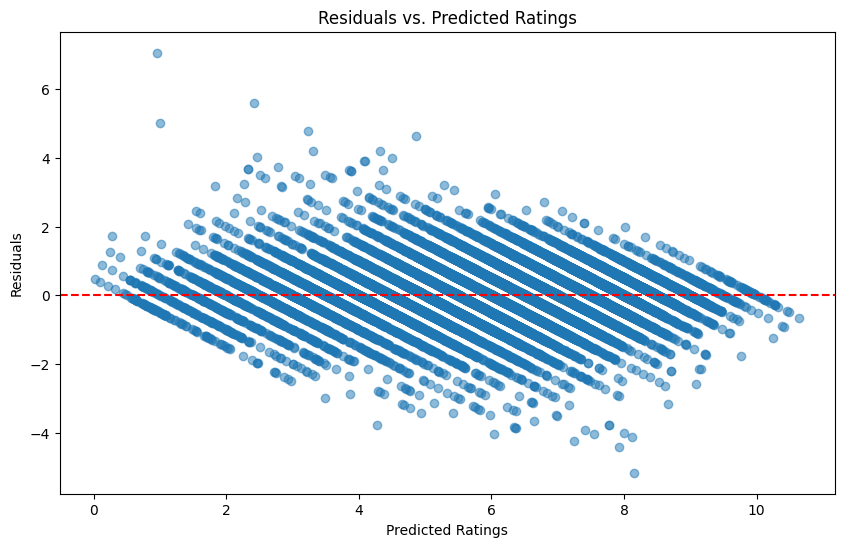

In [18]:
# Assuming test_sep_jan_y is a DataFrame with one column
test_sep_jan_y_array = test_sep_jan_y.squeeze().values  # This converts it to a numpy array

# Now perform the subtraction
residuals = test_sep_jan_y_array - y_pred_test

# Continue with plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

## <span style="color:#ff5f27;"> Register model</span>

In [19]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [20]:
import joblib
joblib.dump(clf, 'xgboost.pkl')

['xgboost.pkl']

In [24]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(train_apr_sep_x)
output_schema = Schema(train_apr_sep_y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

test_example = [
    39971,  # beer_beerid
    'Boggart Pants',  # beer_name
    3741,  # beer_brewerid
    4.5,  # beer_abv
    'DJMonarch',  # review_profilename
    '2006-01-01T00:00:00.000Z',  # review_time
    0,  # style_abbey_dubbel
    1,  # style_abbey_tripel
    0,  # style_abt_quadrupel
    # Continue for all styles...
    0,  # style_zwickel_keller_landbier
    0.5,  # review_appearance
    0.555556,  # review_aroma
    0.75,  # review_palate
    0.666667,  # review_taste
    6.25,  # review_overall
    6.392361,  # avg_overall
    6.094898,  # avg_aroma
    6.753061,  # avg_palate
    6.517347,  # avg_taste
    8.336735,  # avg_appearance
    4308  # review_count
]

In [25]:
# Ensure you have calculated some regression metrics if not already done
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_sep_jan_y, y_pred_test)
r2 = r2_score(test_sep_jan_y, y_pred_test)

metrics = {"MSE": mse, "R^2": r2}

In [26]:
# Create and register the model
model = mr.python.create_model(
    name="BeerRatingPredictionModel",
    metrics=metrics,
    description="XGBoost regression model for predicting beer ratings",
    input_example=test_example,
    model_schema=model_schema
)

# Save the model in the model registry
model.save('xgboost.pkl')

Uploading: 100.000%|██████████| 748/748 elapsed<00:01 remaining<00:0000:02,  2.44it/s]
Uploading: 100.000%|██████████| 181/181 elapsed<00:01 remaining<00:00<00:05,  1.26s/it]
Uploading: 100.000%|██████████| 8208/8208 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/550037/models/BeerRatingPredictionModel/1


Model(name: 'BeerRatingPredictionModel', version: 1)